In [9]:
from quantities import m, pF, ohm, Hz, MHz, s, degree, GHz

import numpy as np
from numpy import pi

from sympy import latex
from IPython.display import display, Math

import skrf as rf
from scipy.optimize import minimize


def Units(x, units):
    x.units = units
    return x

def split_off_units(x, decimal_places = None):
    if decimal_places is not None:
        x = round(x, decimal_places)
    x = str(x)
    return f'{x.split()[0]} \\text{{{x.split()[1]} }}' 


light_speed = 299792458 * m/s

j = 1j

# Prelab Section
---
### 1.
Design a quarter-wave matching transformer to match a $10 \Omega$ load to a $50 \Omega$ line. Assume a design frequency of $300\text{MHz}$.


The matching equation for a quarter-wave transformer is:
$$Z_0 = \sqrt{Z_\text{in}(L=0.25\lambda)Z_L}$$

Assuming the wave propagates in free space, the wavelength is given by $$\lambda =\frac{c}{f}$$ and so $$L=\frac{c}{4f}$$

In [10]:
Z_in = 50*ohm
Z_L = 10*ohm
f = 300*MHz

Z0 = np.sqrt(Z_in*Z_L)
display(Math(f'Z_0 = {split_off_units(Z0, 3)}'))

L = Units(light_speed/(4*f), 'cm')
display(Math(f'L = {split_off_units(L, 3)}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### 2. 
Design a single-stub tuner to match a load impedance comprising a
series RC where $R = 60\Omega$ and $C = 0.995\text{pF}$ to a $50\Omega$ line. Assume a
design frequency of $2\text{GHz}$. 
Find the solution using the shortest length
of open-circuited stub.

In [11]:
f = 2*GHz
Z_L = 60*ohm + 1/(j*2*pi*f*0.995*pF)
Z_0 = 50*ohm

# Frequency, wavenumber and transmission line media
freq = rf.Frequency(start=1, stop=3, npoints=301, unit='GHz')
k = freq.w / rf.c #angular frequency over speed of light
line = rf.DefinedGammaZ0(freq, gamma= k*j, z0=Z_0)

def resulting_network(theta_delay, theta_stub):
    """
    Return a loaded single stub matching network

    NB: theta_delay and theta_stub lengths are in deg
    """
    delay_load = line.delay_load(rf.zl_2_Gamma0(Z_0, Z_L), theta_delay)
    shunted_stub = line.shunt_delay_open(theta_stub)
    return shunted_stub ** delay_load

def optim_fun(x):
    return resulting_network(x[0], x[1])['2GHz'].s_mag.ravel()

x0 = (50, 50)
bnd = (0, 180)
theta_delay, theta_stub = minimize(optim_fun, x0, bounds=(bnd, bnd)).x 

line_delay_length = Units(theta_delay*degree*light_speed/(360*degree*f), 'cm')
stub_length = Units(theta_stub*degree*light_speed/(360*degree*f), 'cm')

In [12]:
display(Math(f'\\theta_{{\\text{{delay}}}} = {round(theta_delay, 3)} ^\\circ' ))
display(Math(f'\\theta_{{\\text{{stub}}}}={round(theta_stub, 3)} ^\\circ'))

display(Math(f'\\text{{Distance between stub and load}} = {split_off_units(round(line_delay_length, 3))}'))
display(Math(f'\\text{{Stub length}} = {split_off_units(round(stub_length, 3))}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Lab Section
---
### 1.
Quarter-wave transformer matching network:

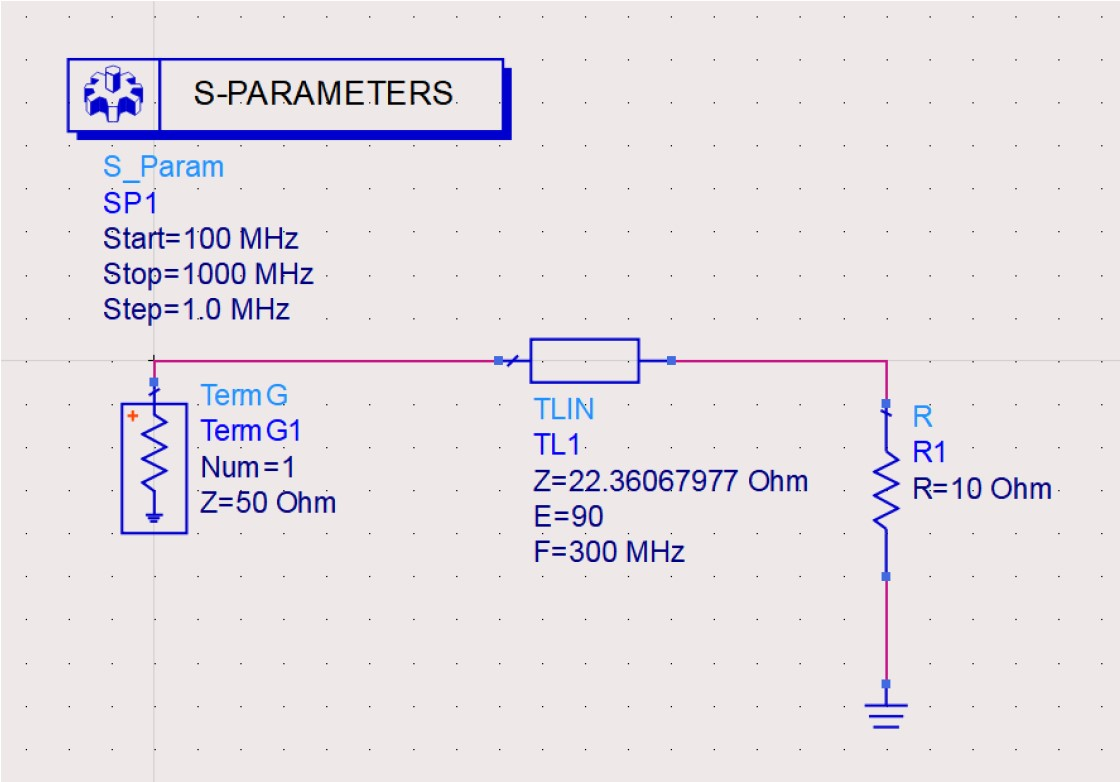

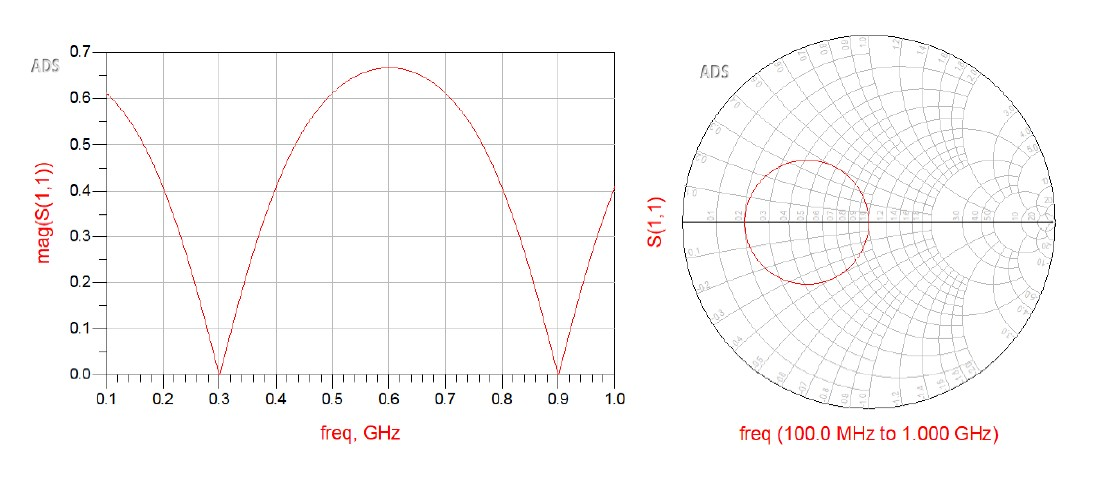

#### a. 
When you plot the $S_{11}$ for the quarter-wave transformer matching network, you should see additional frequencies at which the load is matched to the source. Why is that happening?

For a quarter-wave matching network, the load and input reactances are matched (or, more specifically, they're the negatives of each other) whenever $L = (2n+1)\frac{\lambda}{4}$, for $n = 0, 1, 2, 3...$.  Since $f\propto \frac{c}{\lambda}$ and $\Gamma$ is a function of load reactance, we get this dependency of $\Gamma$ on $f$.

### 2. 
Single-stub matching network:

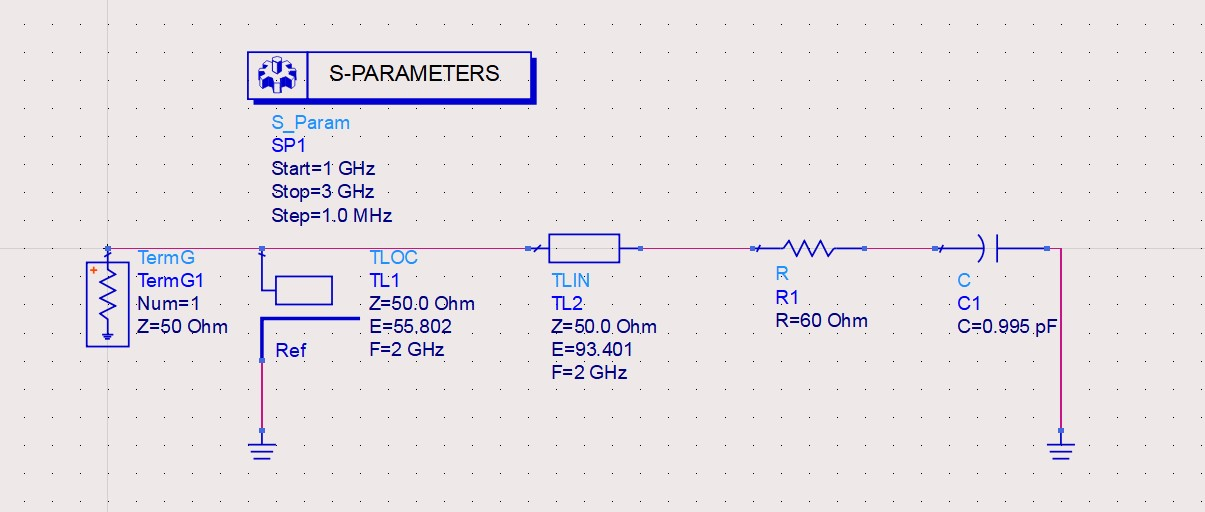

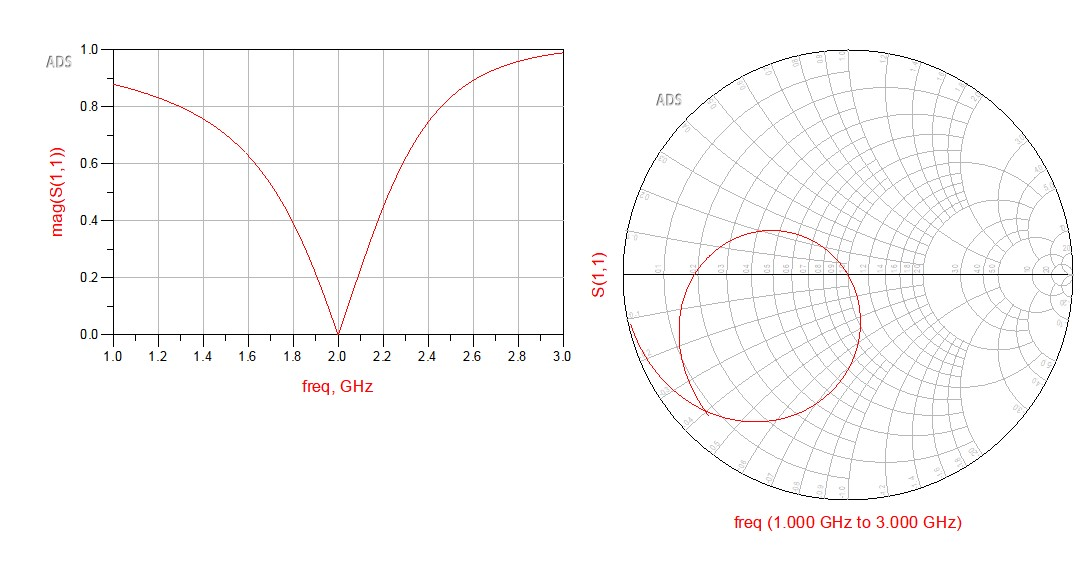


#### a.

There is another single-stub solution using open-circuited stub to match the RC load to 50\Omega transmission line. Design that matching network, implement it in ADS (using ideal component) and plot $S_{11}$. 

In [13]:
x0 = (40, 90) #initial guess for minimization function to use
bnd = (0, 180)
theta_delay, theta_stub = minimize(optim_fun, x0, bounds=(bnd, bnd), method='Nelder-Mead').x 

line_delay_length = Units(theta_delay*degree*light_speed/(360*degree*f), 'cm')
stub_length = Units(theta_stub*degree*light_speed/(360*degree*f), 'cm')

In [14]:
display(Math(f'\\theta_{{\\text{{delay}}}} = {round(theta_delay, 3)} ^\\circ' ))
display(Math(f'\\theta_{{\\text{{stub}}}}={round(theta_stub, 3)} ^\\circ'))

display(Math(f'\\text{{Distance between stub and load}} = {split_off_units(round(line_delay_length, 3))}'))
display(Math(f'\\text{{Stub length}} = {split_off_units(round(stub_length, 3))}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

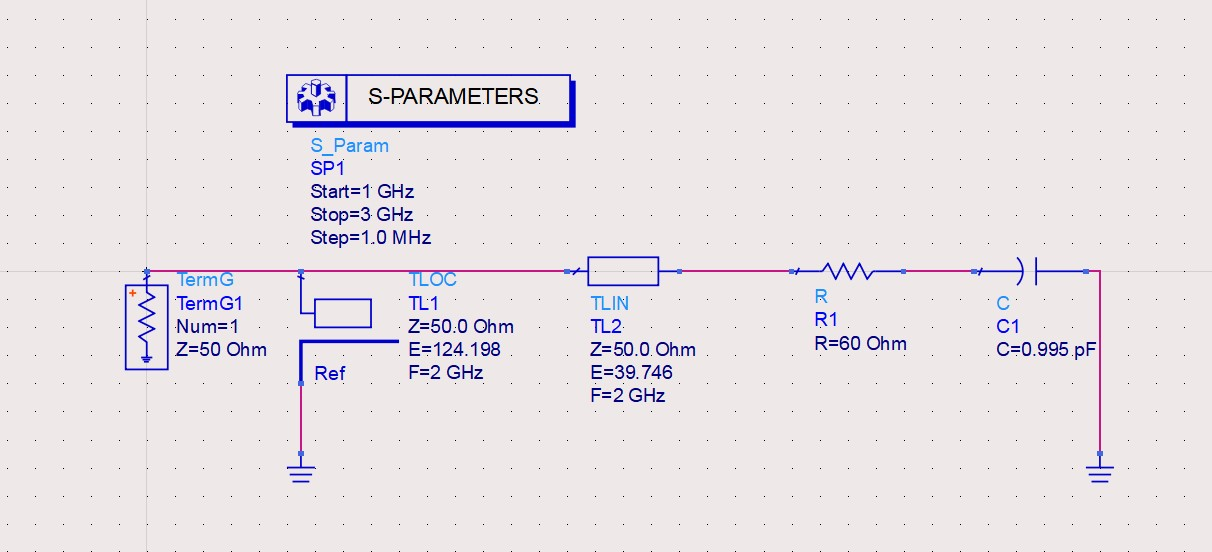

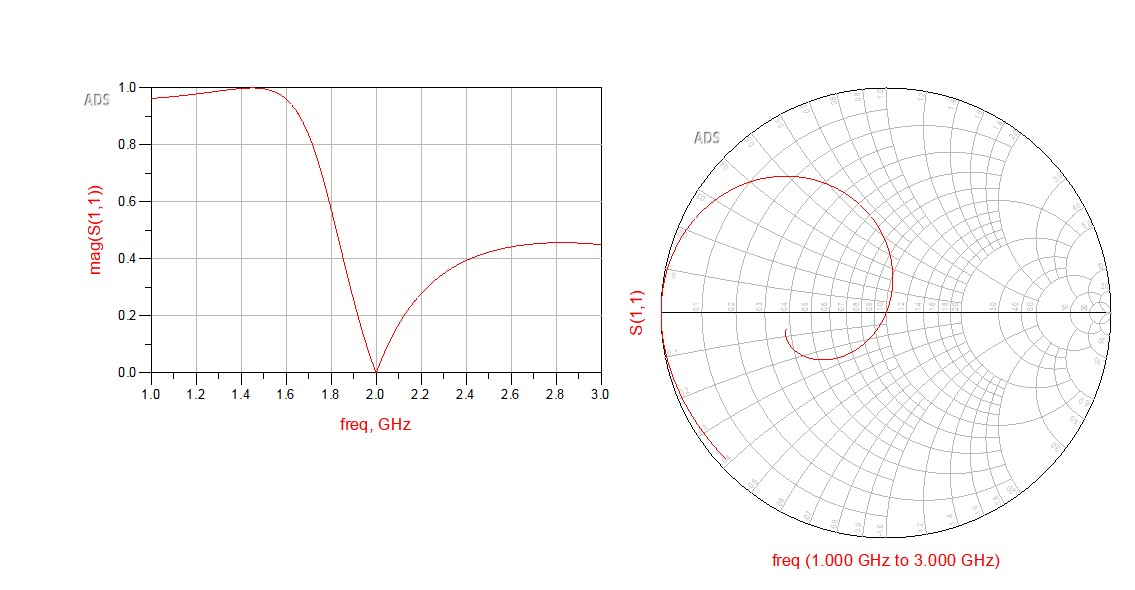

#### b.
Compare your results for this solution to the ones for your original solution.

For the first solution, the reflection coefficient magnitude, $\Gamma$, quickly gets close to 1 as the frequency deviates from $2\text{GHz}$ in either direction.  
More specifically, it seems that, as $f\rightarrow 1$, $\Gamma \rightarrow 0.9$ and as $f\rightarrow 3$, $\Gamma \rightarrow 1$. In other words, for the first solution, while we can use a shorter overall circuit (as the total distance given by distance between stub and load + stub length is larger for the second solution), the cost is that, if the frequency deviates much at all from $2\text{GHz}$ in either direction, a lot of power will be wasted.  

On the other hand, while, for the second solution, $\Gamma \rightarrow 1$ more quickly as $f \rightarrow 1$ than it goes to $0.9$ for the first solution, for the second solution, as $f\rightarrow 3$, $\Gamma \rightarrow 0.5$.  Hence, for the second solution, small deviations from $2\text{GHz}$ towards the right will result in less power loss than they would for the first solution.  The tradeoff is that we have a longer circuit, as well as the fact that small deviations _to the left_ will result in _larger_ power losses.   